<a href="https://colab.research.google.com/github/Faizaa01/Machine_Learning_Fundamentals/blob/main/Outlier_handling_and_Feature_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [3]:
uploaded = files.upload()

df = pd.read_csv("heart.csv")
df.head(5)

Saving heart.csv to heart (1).csv


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


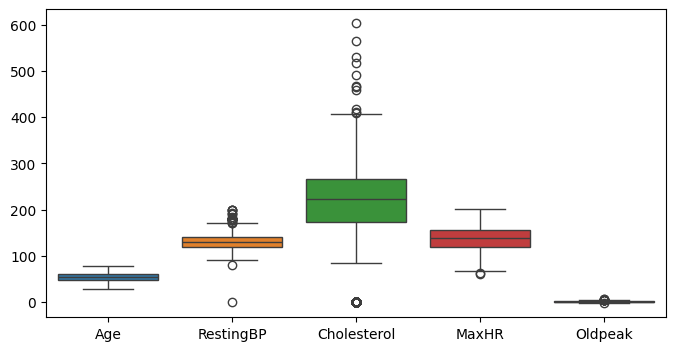

In [4]:
num_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
plt.figure(figsize=(8,4))
sns.boxplot(data=df[num_cols])
plt.show()

In [5]:
col = "Cholesterol"
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3-Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers = df[(df[col]<lower_bound) | (df[col]>upper_bound)]
print(len(outliers))

183


In [9]:
df_no_outliers = df[(df[col]>=lower_bound) & (df[col]<=upper_bound)]
len(df_no_outliers)

df_cap = df.copy()
df_cap[col] = df_cap[col].clip(lower_bound, upper_bound)


In [11]:
df_log = df.copy()
df_log[col + "log"] = np.log(df_log[col]+1)
# df_log.head(5)

In [13]:
from sklearn.preprocessing import PolynomialFeatures

poly_cols = ["Age", "MaxHR"]
poly= PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[poly_cols])
poly_feature_names = poly.get_feature_names_out(poly_cols)

print(poly_features.shape)
print(poly_feature_names)

(918, 5)
['Age' 'MaxHR' 'Age^2' 'Age MaxHR' 'MaxHR^2']


In [15]:
df["Age_bin"] = pd.cut(
    df["Age"],
    bins = [0, 30, 50, 70, 100],
    labels = ["Young", "Middle-aged", "Senior", "Old"]
)
print(df[["Age", "Age_bin"]].head(10))

   Age      Age_bin
0   40  Middle-aged
1   49  Middle-aged
2   37  Middle-aged
3   48  Middle-aged
4   54       Senior
5   39  Middle-aged
6   45  Middle-aged
7   54       Senior
8   37  Middle-aged
9   48  Middle-aged


In [21]:
def bp_risk(bp):
  if(bp<120):
    return "Low"
  elif(bp<140):
    return "Medium"
  else:
    return "High"

def oldpeak_risk(op):
  if(op == 0):
    return "No Stress"
  elif(op<2):
    return "Moderate Stress"
  else:
    return "High Stress"

df["BP_Risk"] = df["RestingBP"].apply(bp_risk)
df["Oldpeak_Risk"] = df["Oldpeak"].apply(oldpeak_risk)

df[["RestingBP", "BP_Risk", "Oldpeak", "Oldpeak_Risk"]].head(10)

,RestingBP,BP_Risk,Oldpeak,Oldpeak_Risk
0,140,High,0.0,No Stress
1,160,High,1.0,Moderate Stress
2,130,Medium,0.0,No Stress
3,138,Medium,1.5,Moderate Stress
4,150,High,0.0,No Stress
5,120,Medium,0.0,No Stress
6,130,Medium,0.0,No Stress
7,110,Low,0.0,No Stress
8,140,High,1.5,Moderate Stress
9,120,Medium,0.0,No Stress


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression


num_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
cat_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(drop="first"))
])

preprocess = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

clf = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(acc)
print(classification_report(y_test, y_pred))

0.8434782608695652
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        98
           1       0.90      0.82      0.86       132

    accuracy                           0.84       230
   macro avg       0.84      0.85      0.84       230
weighted avg       0.85      0.84      0.84       230

